# Assignment 3: Classification of Handwritten Digits

Vasileios Dimopoulos

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Below we load the data from the .xlsx file and insert them into np arrays.

In [2]:
train_y = pd.read_excel("data.xlsx", sheet_name="dzip",header=None)
train_y = train_y.to_numpy()
train_y = train_y.flatten()
train_X = pd.read_excel("data.xlsx", sheet_name="azip",header=None)
train_X = train_X.to_numpy()
test_y = pd.read_excel("data.xlsx", sheet_name="dtest",header=None)
test_y = test_y.to_numpy()
test_y = test_y.flatten()
test_X = pd.read_excel("data.xlsx", sheet_name="testzip",header=None)
test_X = test_X.to_numpy()

In [3]:
train_X

array([[-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       ...,
       [-1.   , -0.671, -1.   , ..., -1.   , -1.   , -1.   ],
       [-1.   , -0.828, -1.   , ..., -1.   , -1.   , -1.   ],
       [-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ]])

In [4]:
train_y

array([6, 5, 4, ..., 7, 9, 8], dtype=int64)

In [5]:
print(f"Train X: {train_X.shape[0]} x {train_X.shape[1]}")
print(f"Train y: {train_y.shape[0]}")

Train X: 256 x 1707
Train y: 1707


We create a function for printing the images from 256 dimension vectors, to 16x16 arrays of pixels.

In [6]:
import matplotlib.pyplot as plt

def display_image(image_vector):
    image_matrix = image_vector.reshape(16, 16)
    plt.imshow(image_matrix, cmap='gray')
    plt.show()

We create a function that creates the Truncated SVD for the matrices of each digits rows, and keeps an input size of basis vectors. The function returns a dictionary with digits as keys and their bases as values.

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge

def calculate_svd_for_classes(train_data, train_labels, num_basis_vectors):
    svd_bases = {}

    for digit in range(10):
        digit_data = train_data[train_labels == digit]

        svd = TruncatedSVD(n_components=num_basis_vectors)
        svd.fit(digit_data)
        svd_bases[digit] = svd.components_

    return svd_bases

We create a method that for given picture vectors calculates the relative residuals from their representation each digit's basis vectors. We keep the mins residual class, as the predicted class for each image vector.

In [8]:
def classify_with_svd_bases(test_X, svd_bases):
    predictions = []

    for data_point in test_X:
        min_residual = float('inf')
        predicted_class = None

        for class_label, bases in svd_bases.items():
            residuals = [np.linalg.norm(data_point - np.dot(data_point, basis) * basis) for basis in bases]
            avg_residual = np.mean(residuals)
            if avg_residual < min_residual:
                min_residual = avg_residual
                predicted_class = class_label

        predictions.append(predicted_class)

    return predictions


For basis vector number from 5 to 20, we predict the labels for our test data and measure the accuracy of the classification with the real labels. We also keep the vector number that produced the best class weighted f1 scores, for each class.

Number of Basis Vectors | Accuracy
---------------------------------
5                        | 0.8959%
6                        | 0.8964%
7                        | 0.9033%
8                        | 0.9058%
9                        | 0.9108%
10                       | 0.9178%
11                       | 0.9203%
12                       | 0.9223%
13                       | 0.9213%
14                       | 0.9233%
15                       | 0.9283%
16                       | 0.9273%
17                       | 0.9278%
18                       | 0.9292%
19                       | 0.9287%
20                       | 0.9263%

Digit | Basis Vector Number with most F1-Score
--------------------------------------
0     | 18 (0.9683)
1     | 19 (0.9646)
2     | 12 (0.9110)
3     | 18 (0.8997)
4     | 20 (0.8993)
5     | 18 (0.8974)
6     | 16 (0.9617)
7     | 18 (0.9420)
8     | 17 (0.9141)
9     | 16 (0.9030)


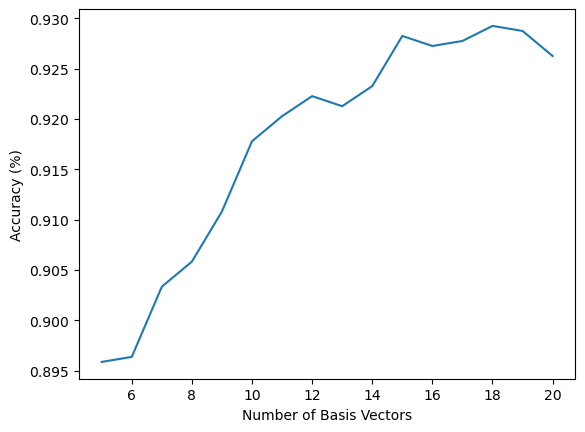

In [9]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_results = []
class_best_f1_score = [0,0,0,0,0,0,0,0,0,0]
class_best_basis_size = [0,0,0,0,0,0,0,0,0,0]

for num_basis_vectors in range(5, 21):
    svd_bases = calculate_svd_for_classes(train_X.T, train_y, num_basis_vectors=num_basis_vectors)
    predictions = classify_with_svd_bases(test_X.T, svd_bases)
    accuracy = accuracy_score(test_y, predictions)
    accuracy_results.append((num_basis_vectors, accuracy))
    classification_report_result = classification_report(test_y, predictions, output_dict=True)
    f1_scores_per_class = [classification_report_result[str(label)]['f1-score'] for label in range(10)]
    for i in range(10):
        if f1_scores_per_class[i] > class_best_f1_score[i]:
            class_best_f1_score[i] = f1_scores_per_class[i]
            class_best_basis_size[i] = num_basis_vectors

print("Number of Basis Vectors | Accuracy")
print("---------------------------------")
for result in accuracy_results:
    print(f"{result[0]:<24} | {result[1]:.4f}%")

print("")
print("Digit | Basis Vector Number with most F1-Score")
print("--------------------------------------")
for i in range(10): 
    print(f"{i}     | {class_best_basis_size[i]} ({class_best_f1_score[i]:.4f})")

plt.plot(*zip(*accuracy_results))
plt.xlabel('Number of Basis Vectors')
plt.ylabel('Accuracy (%)')
plt.show()

As we can see the best basis vector number (max accuracy) was 18. Below we create the classifier for this size of base and measure the evaluation metrics for each class.

In [10]:
svd_bases = calculate_svd_for_classes(train_X.T, train_y, num_basis_vectors=18)
predictions = classify_with_svd_bases(test_X.T, svd_bases)
classification_report_result = classification_report(test_y, predictions)
report_dict = classification_report(test_y, predictions,output_dict=True)
best_weighted_f1 = report_dict['weighted avg']['f1-score']
print("Classification Report:")
print(classification_report_result)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       359
           1       0.95      0.98      0.96       264
           2       0.94      0.87      0.91       198
           3       0.90      0.89      0.90       166
           4       0.88      0.92      0.90       200
           5       0.92      0.88      0.90       160
           6       0.96      0.95      0.96       170
           7       0.95      0.94      0.94       147
           8       0.93      0.89      0.91       166
           9       0.89      0.92      0.90       177

    accuracy                           0.93      2007
   macro avg       0.93      0.92      0.92      2007
weighted avg       0.93      0.93      0.93      2007



Classes 3,4,5,9 had the least f1 score so we can assume that they were the harder to classify. We will print them below to see if the images can tell us where the difficulty in the classification is based.

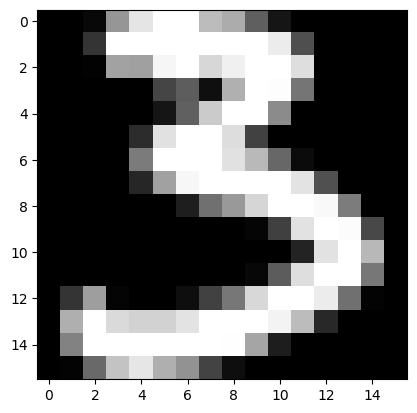

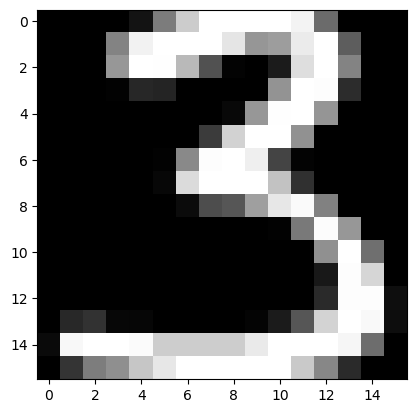

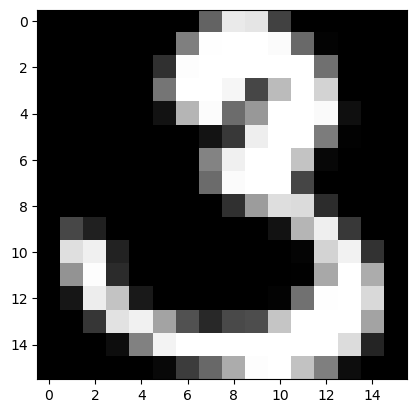

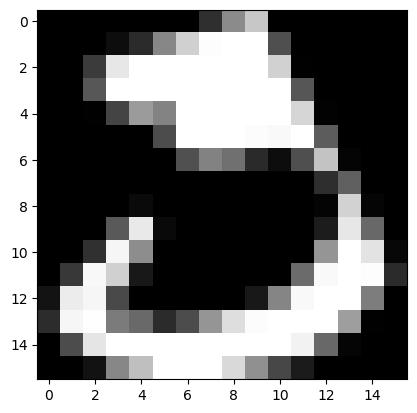

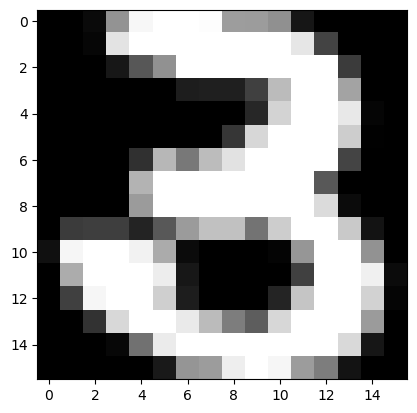

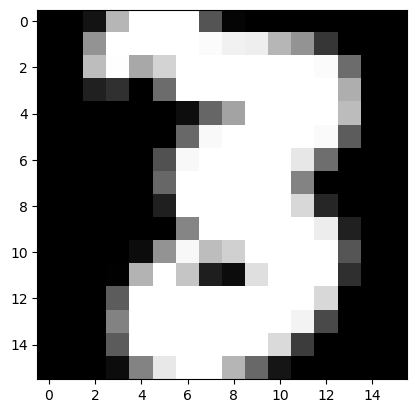

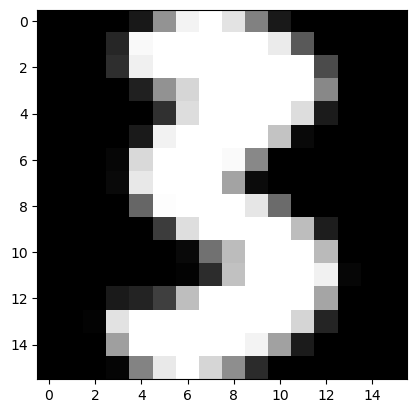

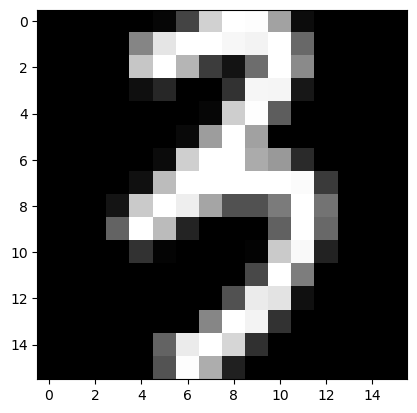

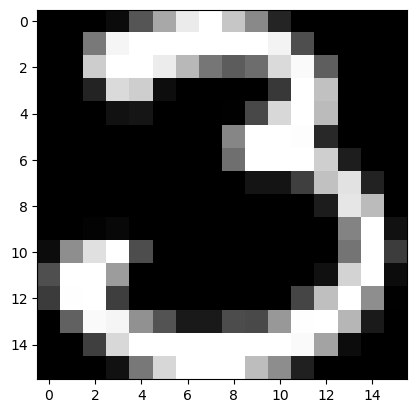

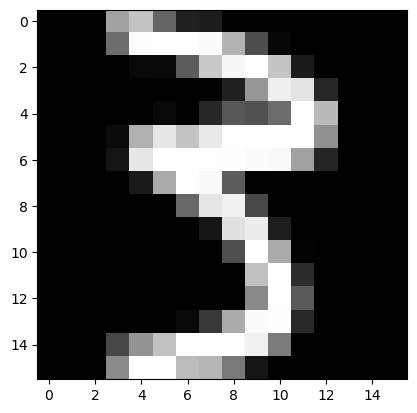

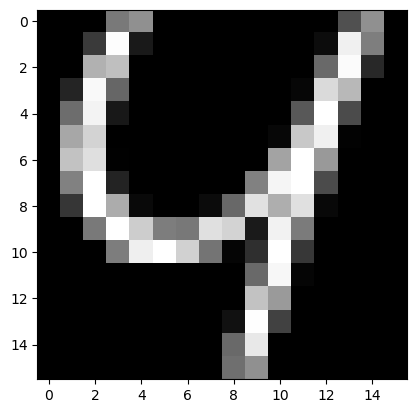

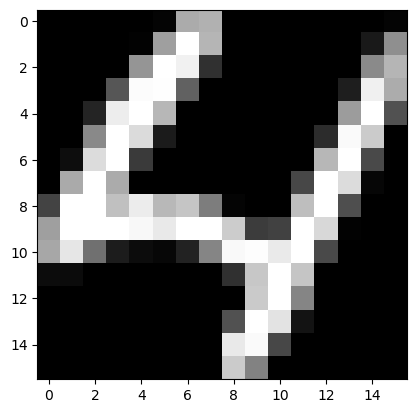

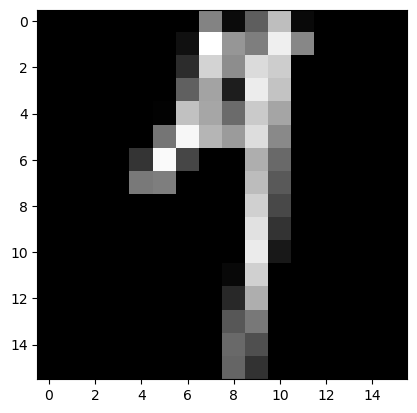

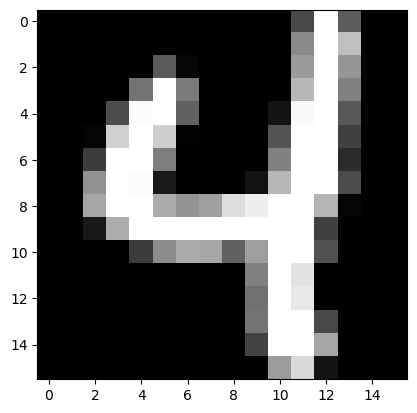

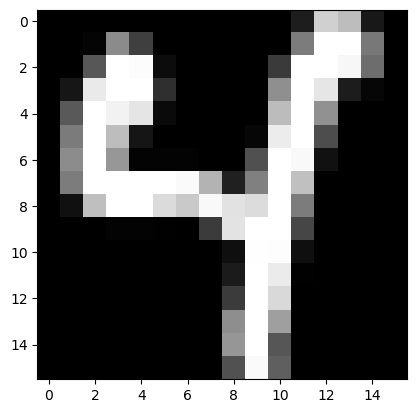

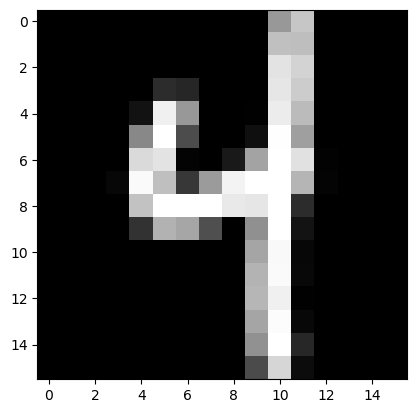

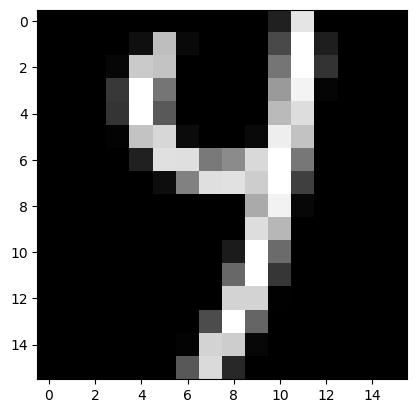

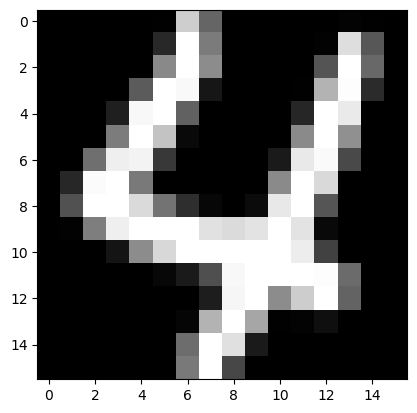

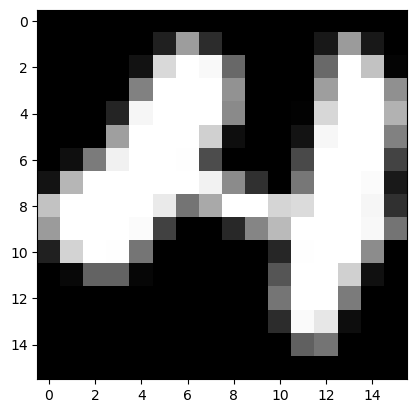

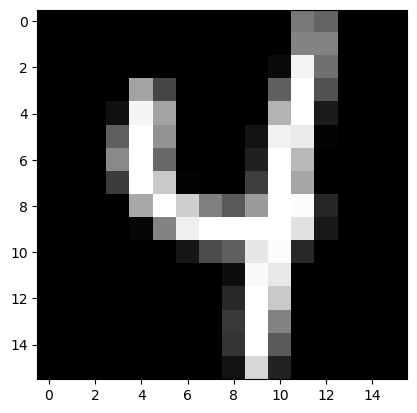

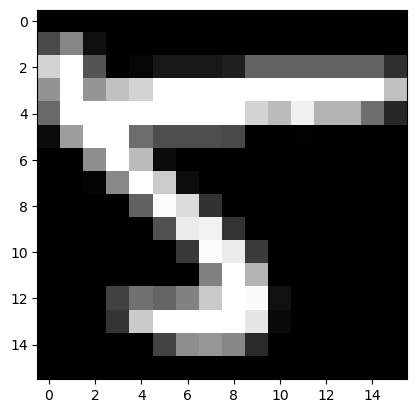

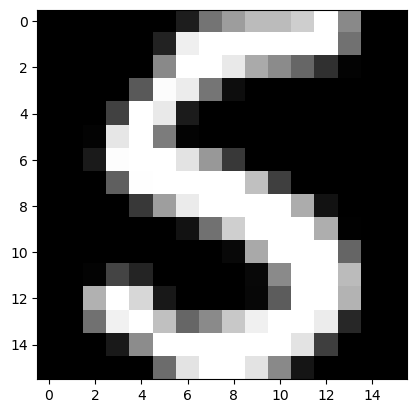

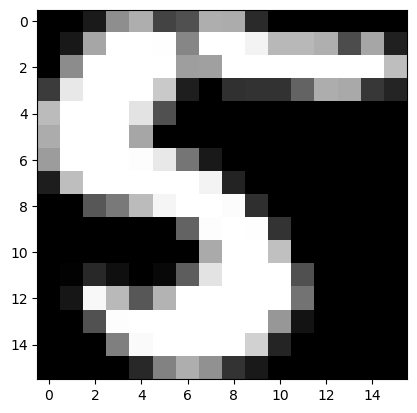

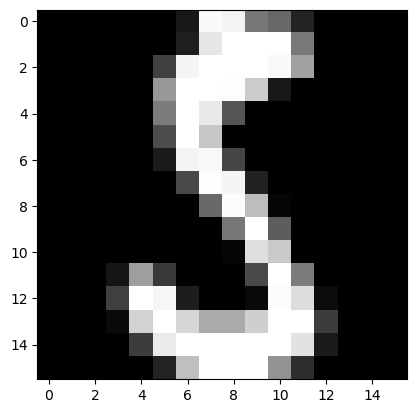

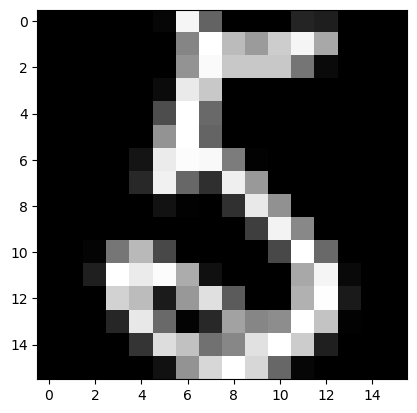

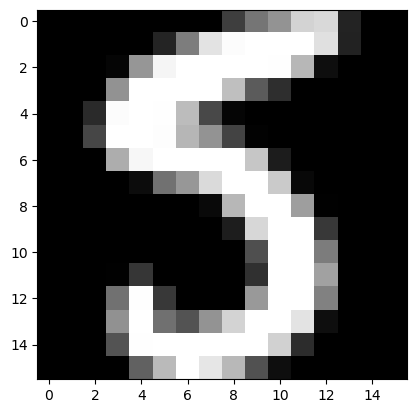

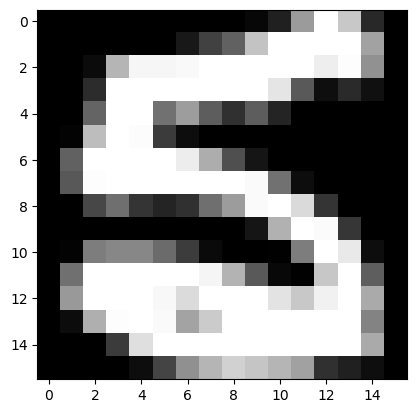

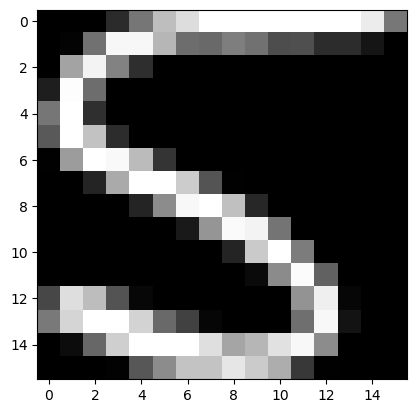

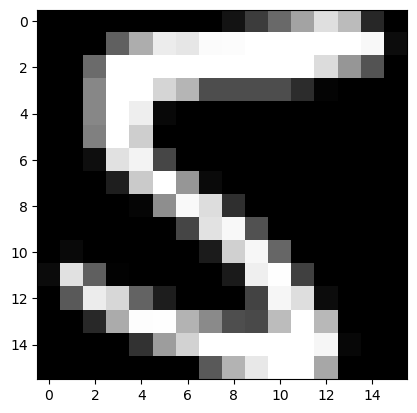

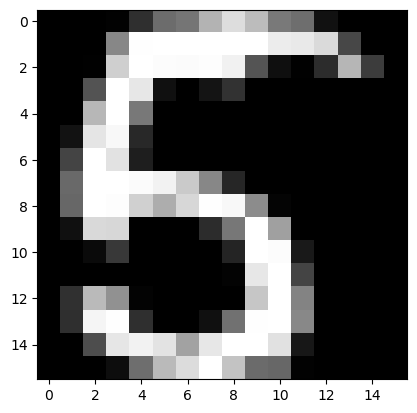

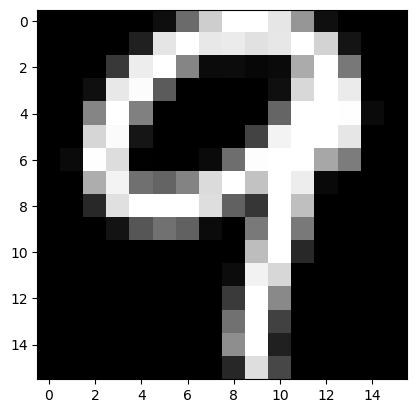

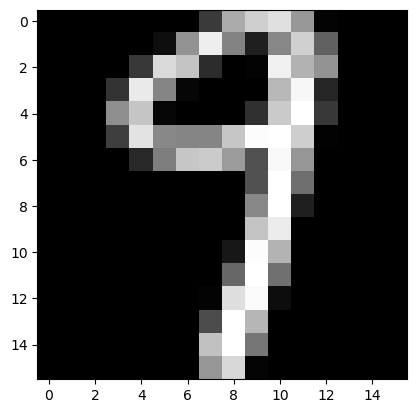

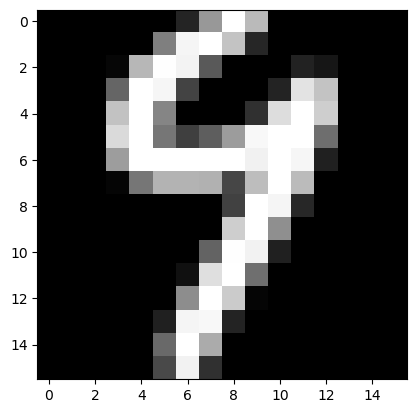

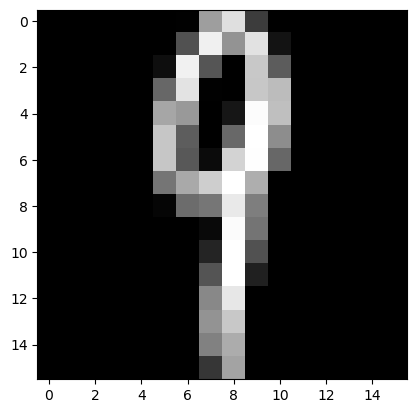

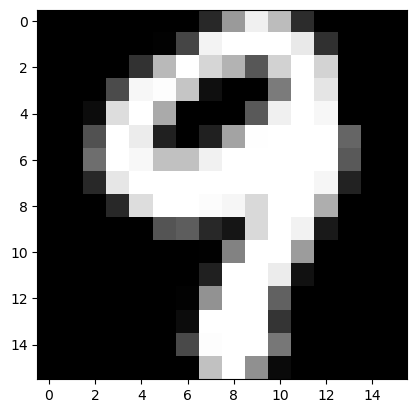

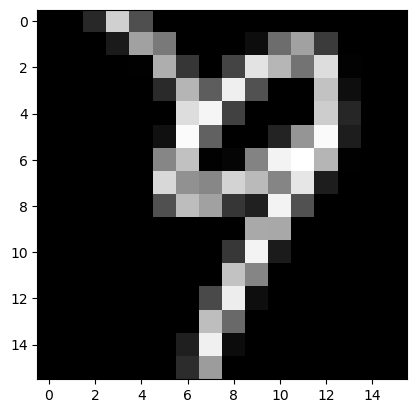

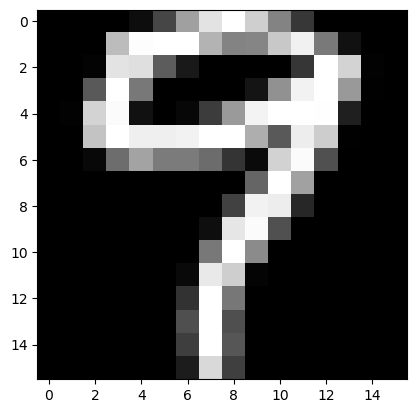

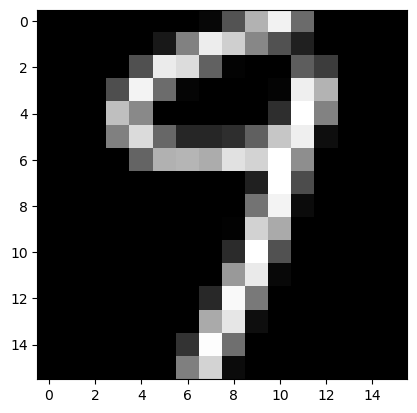

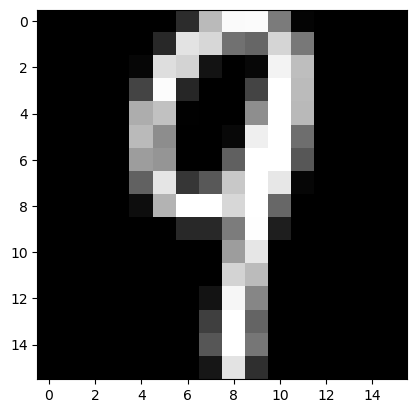

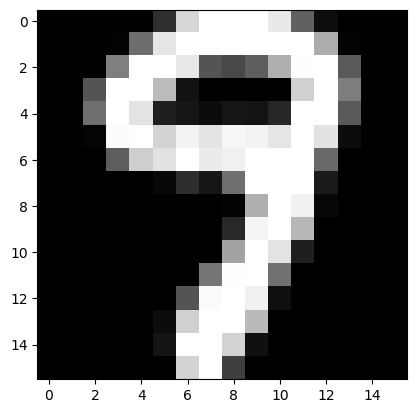

In [11]:
import random
worse_perf_classes = [3,4,5,9]
for class_num in worse_perf_classes:
    matrix = test_X.T[test_y == class_num]
    random_pictures = random.sample(range(matrix.shape[0] + 1), 10)
    for i in random_pictures:
        display_image(matrix[i])

Indeed for all these classes we can see images of digits that are not clear, distorted and probably difficult to classify.

We modify the bases vectors calculation to be able to take a list of vector numbers (for each class) and return the bases accordingly.

In [12]:
def calculate_different_svd_for_classes(train_data, train_labels, num_basis_vectors_list):
    svd_bases = {}

    for digit in range(10):
        digit_data = train_data[train_labels == digit]

        svd = TruncatedSVD(n_components=num_basis_vectors_list[digit])
        svd.fit(digit_data)
        svd_bases[digit] = svd.components_

    return svd_bases


For every digit and every combination of digits we will randomly reduce the basis (5 times) size of them to see if the results improve.

In [13]:
import random
from sklearn.metrics import f1_score
from itertools import combinations

numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
numbers_list = [[0], [1], [2], [3], [4], [5], [6], [7],[8], [9]]
combinations_list = list(combinations(numbers, 2))
numbers_list.extend(combinations_list)
print(numbers_list)
trial = 1
for changes in numbers_list:
    for i in range(5):
        changed_basis_size = [18,18,18,18,18,18,18,18,18,18]
        print(f"Trial {trial}:")
        print(f"Changed class bases: {changes}")
        for class_num in changes:
            num = random.randint(15, 17)
            changed_basis_size[class_num] = num
            print(f" \tChanged digit {class_num} basis size to {num}")

        svd_bases = calculate_different_svd_for_classes(train_X.T, train_y, changed_basis_size)
        predictions = classify_with_svd_bases(test_X.T, svd_bases)
        weighted_f1 = f1_score(test_y, predictions, average='weighted')
        print(f"Weighted F1 Score: {weighted_f1}")
        if (weighted_f1 > best_weighted_f1):
            print("Improved")
        print("")
        trial += 1

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]
Trial 1:
Changed class bases: [0]
 	Changed digit 0 basis size to 15
Weighted F1 Score: 0.9129521947925393

Trial 2:
Changed class bases: [0]
 	Changed digit 0 basis size to 15
Weighted F1 Score: 0.9129656757115104

Trial 3:
Changed class bases: [0]
 	Changed digit 0 basis size to 16
Weighted F1 Score: 0.9193672490509618

Trial 4:
Changed class bases: [0]
 	Changed digit 0 basis size to 15
Weighted F1 Score: 0.9124505397243592

Trial 5:
Changed class bases: [0]
 	Changed digit 0 basis size to 17
Weighted F1 Score: 0.9249539587143074

Trial 6:
Changed class bases: [1]
 	Changed digit

Weighted F1 Score: 0.9137789744421227

Trial 67:
Changed class bases: (0, 4)
 	Changed digit 0 basis size to 17
 	Changed digit 4 basis size to 16
Weighted F1 Score: 0.918390039172644

Trial 68:
Changed class bases: (0, 4)
 	Changed digit 0 basis size to 17
 	Changed digit 4 basis size to 15
Weighted F1 Score: 0.8970581851116407

Trial 69:
Changed class bases: (0, 4)
 	Changed digit 0 basis size to 16
 	Changed digit 4 basis size to 17
Weighted F1 Score: 0.9209549442195832

Trial 70:
Changed class bases: (0, 4)
 	Changed digit 0 basis size to 15
 	Changed digit 4 basis size to 16
Weighted F1 Score: 0.9082318604202775

Trial 71:
Changed class bases: (0, 5)
 	Changed digit 0 basis size to 16
 	Changed digit 5 basis size to 16
Weighted F1 Score: 0.9130162570691818

Trial 72:
Changed class bases: (0, 5)
 	Changed digit 0 basis size to 17
 	Changed digit 5 basis size to 17
Weighted F1 Score: 0.9225037578652502

Trial 73:
Changed class bases: (0, 5)
 	Changed digit 0 basis size to 15
 	Chang

Weighted F1 Score: 0.9214589040951388

Trial 123:
Changed class bases: (1, 7)
 	Changed digit 1 basis size to 15
 	Changed digit 7 basis size to 16
Weighted F1 Score: 0.8953337389444359

Trial 124:
Changed class bases: (1, 7)
 	Changed digit 1 basis size to 16
 	Changed digit 7 basis size to 15
Weighted F1 Score: 0.8912754925334853

Trial 125:
Changed class bases: (1, 7)
 	Changed digit 1 basis size to 15
 	Changed digit 7 basis size to 16
Weighted F1 Score: 0.8953337389444359

Trial 126:
Changed class bases: (1, 8)
 	Changed digit 1 basis size to 15
 	Changed digit 8 basis size to 16
Weighted F1 Score: 0.9022810562142721

Trial 127:
Changed class bases: (1, 8)
 	Changed digit 1 basis size to 16
 	Changed digit 8 basis size to 15
Weighted F1 Score: 0.8936188955303858

Trial 128:
Changed class bases: (1, 8)
 	Changed digit 1 basis size to 17
 	Changed digit 8 basis size to 17
Weighted F1 Score: 0.9221656945366921

Trial 129:
Changed class bases: (1, 8)
 	Changed digit 1 basis size to 15

Weighted F1 Score: 0.9192363480080865

Trial 179:
Changed class bases: (3, 5)
 	Changed digit 3 basis size to 15
 	Changed digit 5 basis size to 15
Weighted F1 Score: 0.9095230665548599

Trial 180:
Changed class bases: (3, 5)
 	Changed digit 3 basis size to 15
 	Changed digit 5 basis size to 15
Weighted F1 Score: 0.9104883902943908

Trial 181:
Changed class bases: (3, 6)
 	Changed digit 3 basis size to 17
 	Changed digit 6 basis size to 16
Weighted F1 Score: 0.9085971922436231

Trial 182:
Changed class bases: (3, 6)
 	Changed digit 3 basis size to 16
 	Changed digit 6 basis size to 17
Weighted F1 Score: 0.9112890865908179

Trial 183:
Changed class bases: (3, 6)
 	Changed digit 3 basis size to 17
 	Changed digit 6 basis size to 15
Weighted F1 Score: 0.8994379147415905

Trial 184:
Changed class bases: (3, 6)
 	Changed digit 3 basis size to 15
 	Changed digit 6 basis size to 15
Weighted F1 Score: 0.8848543335220663

Trial 185:
Changed class bases: (3, 6)
 	Changed digit 3 basis size to 17

Weighted F1 Score: 0.9113599699260871

Trial 235:
Changed class bases: (5, 7)
 	Changed digit 5 basis size to 17
 	Changed digit 7 basis size to 17
Weighted F1 Score: 0.9206083402942904

Trial 236:
Changed class bases: (5, 8)
 	Changed digit 5 basis size to 16
 	Changed digit 8 basis size to 15
Weighted F1 Score: 0.9004119827584538

Trial 237:
Changed class bases: (5, 8)
 	Changed digit 5 basis size to 15
 	Changed digit 8 basis size to 17
Weighted F1 Score: 0.9128244880262043

Trial 238:
Changed class bases: (5, 8)
 	Changed digit 5 basis size to 16
 	Changed digit 8 basis size to 16
Weighted F1 Score: 0.9154868559113759

Trial 239:
Changed class bases: (5, 8)
 	Changed digit 5 basis size to 15
 	Changed digit 8 basis size to 15
Weighted F1 Score: 0.8962675012417669

Trial 240:
Changed class bases: (5, 8)
 	Changed digit 5 basis size to 17
 	Changed digit 8 basis size to 17
Weighted F1 Score: 0.924669856530527

Trial 241:
Changed class bases: (5, 9)
 	Changed digit 5 basis size to 15


We can see in trials 11, 22 and 220 (rest are duplicates of the 3) that the decrease in base vector number that be applied for certain classes, led to the improvement of the total weighted f1 score.